# CIFAR-10 data를 활용한 CNN 모델 설계
---
1. import module
2. Device Check
3. Data Load
4. Data Check(1)
5. Data Check(2)
6. CNN 모델 설계
7. Optimizer, Objective Function 설정
8. Train 데이터 모델 성능 확인
9. Valid 데이터 모델 성능 확인
10. CNN 실행하면서 Train, Test의 Loss 및 Accuracy 확인

In [1]:
# # CUDA error: device-side assert triggered 보완코드 (출력 차원 오류 시)
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 1.import module

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# 2.Device Check

In [3]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
print(f"Pytorch Version: {torch.__version__} \t Device: {DEVICE}")

BATCH_SIZE = 32
EPOCHS = 10

Pytorch Version: 1.10.1 	 Device: cuda


# 3.Data Load

In [4]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = False,
                                 transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


# 4.Data Check(1)

In [5]:
for (X_train, y_train) in train_loader:
    print(f"X_train: {X_train.size()} \t type: {X_train.type()}")
    print(f"y_train: {y_train.size()} \t type: {y_train.type()}")
    break

X_train: torch.Size([32, 3, 32, 32]) 	 type: torch.FloatTensor
y_train: torch.Size([32]) 	 type: torch.LongTensor


# 5.Data Check(2)

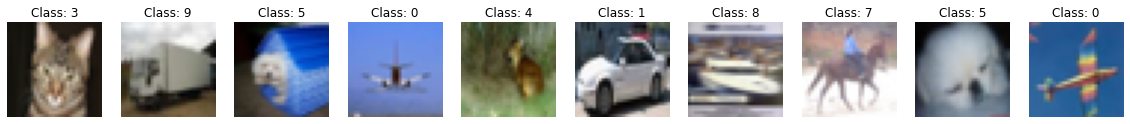

In [6]:
pltSize=2
plt.figure(figsize=(10*pltSize, pltSize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1,2,0)))
    plt.title(f"Class: {y_train[i].item()}")

# 6.CNN 모델 설계

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 8,
            kernel_size = 3,
            padding = 1
        )
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size = 3,
            padding = 1
        )
        self.pool = nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        # Convolution Layer & Pooling Layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Fully Connected Layer
        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        
        return x
        

# 7.Optimizer, Objective Function 설정

In [8]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


# 8.Train Data 모델 성능 확인

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train
    for batch_idx,(image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        output = model(image)
        
        loss = criterion(output, label)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image),
                                                                                 len(train_loader.dataset), 100.*batch_idx/len(train_loader),
                                                                                 loss.item()))

# 9.Valid Data 모델 성능 확인

In [10]:
def evaluate(model, test_loader):
    model.eval()
    
    test_loss=0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += criterion(output, label).item()
            
            prediction = output.max(1, keepdim=True)[1]
            
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 10.CNN 실행하면서 Train, Test의 Loss 및 Accuracy 확인

In [11]:
from tqdm.notebook import tqdm

for Epoch in tqdm(range(1, EPOCHS+1)):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".
    format(Epoch, test_loss, test_accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.279555
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.985454
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.988200
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.711421
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.630551
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.624110
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.599871
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.317067

[EPOCH: 1], 	Test Loss: 0.0478, 	Test Accuracy: 44.32 % 

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.406582
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.227650
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.329861
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.270369
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.518039
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.654671
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.668544
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.547394

[EPOCH: 2], 	Test Loss: 0.0414, 	Test Accuracy: 52.59 % 

Train Epoch: 3